# Pets classification with Fast AI

This project is based on Fast AI course v3 lesson one. We will train an image classifier with Fast AI that detect the different breed of cat and dog.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=nb&ea=open&el=gallery-example&dt=fastai-pet-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
! pip install bentoml
! pip install fastai

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate

## Prepare data

In [8]:
path = untar_data(URLs.PETS); path

PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet')

In [9]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg')]

In [11]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [12]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

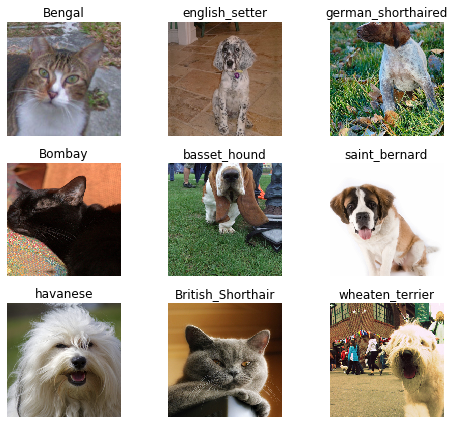

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Train the model 

We are going to use resnet34 to train and classify our images.

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.596629,0.275584,0.085250,30:27


## Test trained model

In [18]:
learn.predict(data.get(10))

(Category Abyssinian,
 tensor(0),
 tensor([8.6080e-01, 7.3687e-02, 1.3511e-04, 3.6431e-04, 2.4942e-04, 5.7515e-03,
         9.3810e-03, 1.2967e-04, 2.2954e-03, 1.5484e-03, 4.5986e-03, 3.2349e-02,
         4.8754e-05, 1.7788e-04, 3.4949e-04, 4.0429e-04, 3.0445e-05, 2.2289e-03,
         2.4436e-04, 6.5400e-05, 4.0302e-05, 5.4603e-05, 1.7140e-04, 8.5141e-05,
         5.5051e-05, 8.4180e-05, 6.7479e-04, 3.4748e-05, 2.2221e-04, 7.1308e-04,
         6.6081e-05, 4.6044e-05, 1.2763e-04, 1.9870e-03, 2.6533e-05, 9.5007e-05,
         6.7421e-04]))

# Save Model with BentoML

In [19]:
%%writefile pet_classification.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(conda_pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('pet_classifer')])
class PetClassification(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_classifer.predict(image)
        return str(result)

Overwriting pet_classification.py


In [20]:
from pet_classification import PetClassification

service = PetClassification.pack(pet_classifer=learn)

saved_path = service.save('/tmp/bentoml_archive')

print(saved_path)

[2019-07-15 16:30:59,375] INFO - Searching for dependant modules of pet_classification:/Users/bozhaoyu/src/bento_gallery/fast-ai/pet-classification/pet_classification.py
[2019-07-15 16:31:17,997] INFO - Copying local python module '/Users/bozhaoyu/src/bento_gallery/fast-ai/pet-classification/pet_classification.py'
[2019-07-15 16:31:17,999] INFO - Done copying local python dependant modules
[2019-07-15 16:31:18,121] INFO - BentoService PetClassification:2019_07_15_cf19d4f2 saved to /tmp/bentoml_archive/PetClassification/2019_07_15_cf19d4f2
/tmp/bentoml_archive/PetClassification/2019_07_15_cf19d4f2


## Using BentoML service archive

In [21]:
from bentoml import load

service = load(saved_path)
print(service.get_service_apis())
api = service.get_service_apis()[0]

print(service.predict(data.get(10)))

(Category Abyssinian, tensor(0), tensor([8.6080e-01, 7.3687e-02, 1.3511e-04, 3.6431e-04, 2.4942e-04, 5.7515e-03,
        9.3810e-03, 1.2967e-04, 2.2954e-03, 1.5484e-03, 4.5986e-03, 3.2349e-02,
        4.8754e-05, 1.7788e-04, 3.4949e-04, 4.0429e-04, 3.0445e-05, 2.2289e-03,
        2.4436e-04, 6.5400e-05, 4.0302e-05, 5.4603e-05, 1.7140e-04, 8.5141e-05,
        5.5051e-05, 8.4180e-05, 6.7479e-04, 3.4748e-05, 2.2221e-04, 7.1308e-04,
        6.6081e-05, 4.6044e-05, 1.2763e-04, 1.9870e-03, 2.6533e-05, 9.5007e-05,
        6.7421e-04]))


## Using archive as CLI TOOL

BentoML makes it very easy to install prediction service as CLI tool.  You can access the prediction inside the terminal.

In [22]:
!pip install {saved_path}

Processing /tmp/bentoml_archive/PetClassification/2019_07_15_cf19d4f2
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-sdn79h6d/wheels/15/55/86/c056a782306374efc3fe3cb3a718d17f7ce520ed28c9b83bd8
Successfully built PetClassification


In [23]:
# Navigate to the notebook directory

!PetClassification predict --input=test.jpg

(Category yorkshire_terrier, tensor(36), tensor([3.7536e-06, 3.0035e-05, 3.4819e-05, 1.6197e-06, 8.4187e-06, 4.6303e-05,
        2.4536e-04, 4.9065e-05, 2.1538e-05, 6.2035e-06, 1.3777e-05, 4.2707e-05,
        6.1237e-06, 4.2110e-06, 2.0479e-06, 9.7227e-06, 3.6145e-06, 2.3943e-05,
        2.1651e-05, 2.8137e-05, 9.4188e-06, 1.9367e-06, 3.8643e-04, 3.4059e-05,
        4.6451e-05, 1.9674e-05, 2.0664e-05, 1.3109e-05, 9.7771e-06, 3.4079e-05,
        6.5182e-06, 8.0877e-06, 3.1994e-04, 4.1494e-06, 5.2632e-06, 2.3144e-05,
        9.9845e-01]))


## Use archive as REST API server

*notes: This doesn't work with Google Colab right now, because we can't access the local port from it.*

In [34]:
!bentoml serve {saved_path}

 * Serving Flask app "PetClassification" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
response from handler <Response 550 bytes [200 OK]>
127.0.0.1 - - [15/Jul/2019 17:05:58] "POST /predict HTTP/1.1" 200 -
^C


### Make requeset to the REST server

*After navigate to the location of this notebook, copy and paste the following code to your terminal and run it to make request*

```bash
curl -i \
--request POST \
--header "Content-Type: multipart/form-data" \
-F "image=@test.jpg" \
localhost:5000/predict
```